In [15]:
from google.colab import files
import pandas as pd
xl_market = files.upload()

Saving new_combined_df.csv to new_combined_df (2).csv


# This notebook includes models that use random train test

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
df = pd.read_csv("new_combined_df (1).csv")

In [18]:
df.shape

(50486, 5)

In [19]:
df.head()

,date,Value,headline_description,source,future_value
0,2017-12-18,2690.16,Business live Bitcoin bubble warnings grow lou...,Guardian,2687.54
1,2017-12-18,2690.16,Christmas tree cutters' labor fight shines lig...,Guardian,2687.54
2,2017-12-18,2690.16,How the American government slowly became a bu...,Guardian,2687.54
3,2017-12-18,2690.16,‘They stole the soul of the city’: how Warsaw'...,Guardian,2687.54
4,2017-12-18,2690.16,"Desperate UK homeowners are cutting prices, sa...",Guardian,2687.54


# Getting percent change value

In [20]:
df['pct_change'] = (
    (df['future_value'] - df['Value']) / df['Value'])
df.head()

,date,Value,headline_description,source,future_value,pct_change
0,2017-12-18,2690.16,Business live Bitcoin bubble warnings grow lou...,Guardian,2687.54,-0.000974
1,2017-12-18,2690.16,Christmas tree cutters' labor fight shines lig...,Guardian,2687.54,-0.000974
2,2017-12-18,2690.16,How the American government slowly became a bu...,Guardian,2687.54,-0.000974
3,2017-12-18,2690.16,‘They stole the soul of the city’: how Warsaw'...,Guardian,2687.54,-0.000974
4,2017-12-18,2690.16,"Desperate UK homeowners are cutting prices, sa...",Guardian,2687.54,-0.000974


visualizing pct change over time

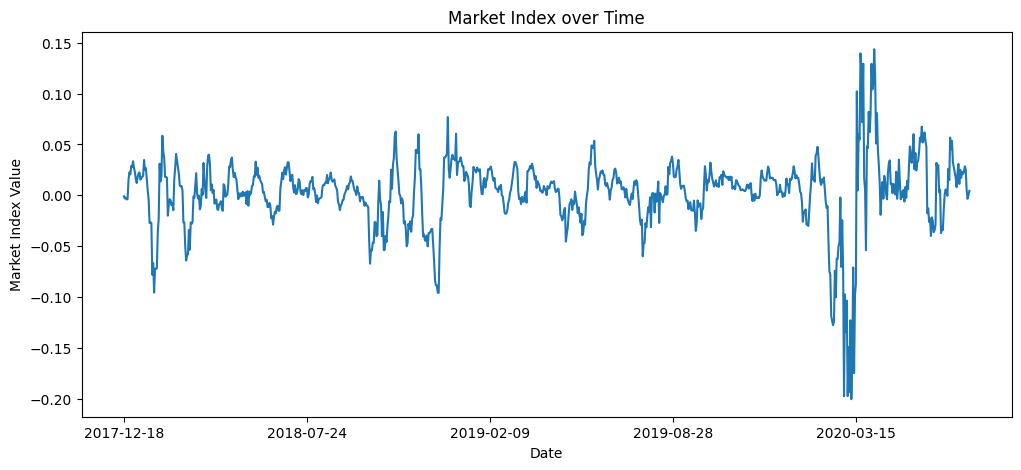

In [21]:
df.groupby("date")["pct_change"].mean().plot(figsize=(12,5))
plt.xlabel("Date")
plt.ylabel("Market Index Value")
plt.title("Market Index over Time")
plt.show()

In [22]:
df['market_trend'] = (df['pct_change'] > 0).astype(int)
df.head()

,date,Value,headline_description,source,future_value,pct_change,market_trend
0,2017-12-18,2690.16,Business live Bitcoin bubble warnings grow lou...,Guardian,2687.54,-0.000974,0
1,2017-12-18,2690.16,Christmas tree cutters' labor fight shines lig...,Guardian,2687.54,-0.000974,0
2,2017-12-18,2690.16,How the American government slowly became a bu...,Guardian,2687.54,-0.000974,0
3,2017-12-18,2690.16,‘They stole the soul of the city’: how Warsaw'...,Guardian,2687.54,-0.000974,0
4,2017-12-18,2690.16,"Desperate UK homeowners are cutting prices, sa...",Guardian,2687.54,-0.000974,0


# logistic regression model on individual headlines using TFID

train test split

In [23]:
from sklearn.model_selection import train_test_split
y = df["market_trend"]  # now 0 or 1

X = df["headline_description"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizing using tfid

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer with accent stripping and lowercasing
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english",
    strip_accents='unicode',  # or 'ascii'
    lowercase=True            # convert all text to lowercase
)

# Fit on training data and transform
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

doing logistic regression on it

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
clf = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier on the TF-IDF vectors
clf.fit(X_train_vectorized, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6476530005941771

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.16      0.24      3590
           1       0.66      0.92      0.77      6508

    accuracy                           0.65     10098
   macro avg       0.59      0.54      0.51     10098
weighted avg       0.61      0.65      0.58     10098


Confusion Matrix:
 [[ 560 3030]
 [ 528 5980]]


# using fnn on each headline individually, and using TFID vectorizer

In [26]:
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()


creating FNN

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(512, input_shape=(X_train_dense.shape[1],), activation='relu'))
model.add(Dropout(0.5))  # prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 117s 226ms/step - accuracy: 0.6376 - loss: 0.6538 - val_accuracy: 0.6488 - val_loss: 0.6416
Epoch 2/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 112s 221ms/step - accuracy: 0.6889 - loss: 0.5766 - val_accuracy: 0.6302 - val_loss: 0.6574
Epoch 3/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 141s 218ms/step - accuracy: 0.8285 - loss: 0.3992 - val_accuracy: 0.6134 - val_loss: 0.7678
Epoch 4/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 110s 219ms/step - accuracy: 0.9410 - loss: 0.1733 - val_accuracy: 0.6154 - val_loss: 1.0556
Epoch 5/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 149s 233ms/step - accuracy: 0.9774 - loss: 0.0714 - val_accuracy: 0.6145 - val_loss: 1.3132


In [28]:
# Predict probabilities on the test set
y_pred_prob = model.predict(X_test_dense)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.33      0.38      3590
           1       0.68      0.77      0.72      6508

    accuracy                           0.62     10098
   macro avg       0.56      0.55      0.55     10098
weighted avg       0.60      0.62      0.60     10098

Confusion Matrix:

[[1188 2402]
 [1472 5036]]


# Using FNN on individual headlines, but making individual days into train test split.  Ex all headlines from december 8th are in train

In [29]:
df["date"] = pd.to_datetime(df["date"])

unique_dates = df["date"].dt.date.unique()


In [30]:
import numpy as np

np.random.seed(42)   # for reproducibility
shuffled_dates = np.random.permutation(unique_dates)


In [31]:
train_size = int(len(shuffled_dates) * 0.8)

train_dates = shuffled_dates[:train_size]
test_dates  = shuffled_dates[train_size:]


In [32]:
train_df = df[df["date"].dt.date.isin(train_dates)].copy()
test_df  = df[df["date"].dt.date.isin(test_dates)].copy()


In [33]:
X_train = train_df["headline_description"]
y_train = train_df["market_trend"]
X_test  = test_df["headline_description"]
y_test  = test_df["market_trend"]

#

using tfid vectorizer

In [34]:
# Create the vectorizer with accent stripping and lowercasing
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english",
    strip_accents='unicode',  # or 'ascii'
    lowercase=True            # convert all text to lowercase
)

# Fit on training data and transform
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [35]:
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()


running FNN model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(512, input_shape=(X_train_dense.shape[1],), activation='relu'))
model.add(Dropout(0.5))  # prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 114s 220ms/step - accuracy: 0.6362 - loss: 0.6535 - val_accuracy: 0.6703 - val_loss: 0.6374
Epoch 2/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 114s 224ms/step - accuracy: 0.7032 - loss: 0.5655 - val_accuracy: 0.6181 - val_loss: 0.6841
Epoch 3/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 153s 247ms/step - accuracy: 0.8326 - loss: 0.3875 - val_accuracy: 0.5920 - val_loss: 0.8533
Epoch 4/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 114s 225ms/step - accuracy: 0.9408 - loss: 0.1672 - val_accuracy: 0.5942 - val_loss: 1.0841
Epoch 5/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.9778 - loss: 0.0707 - val_accuracy: 0.5714 - val_loss: 1.4267


In [37]:
# Predict probabilities on the test set
y_pred_prob = model.predict(X_test_dense)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.40      0.30      0.34      3625
           1       0.65      0.74      0.69      6276

    accuracy                           0.58      9901
   macro avg       0.52      0.52      0.52      9901
weighted avg       0.56      0.58      0.56      9901

Confusion Matrix:

[[1084 2541]
 [1630 4646]]


It goes down when you seperate out train and test by day, however barely.  This implies that there is some correlation between the days, however not enough to truly affect the model considerably.  This would make sense as for example on march 13th 2020 all headlines would look simular, allowing the model to predict any simular headlines very easily that it went down.

In [38]:
df.head()

,date,Value,headline_description,source,future_value,pct_change,market_trend
0,2017-12-18,2690.16,Business live Bitcoin bubble warnings grow lou...,Guardian,2687.54,-0.000974,0
1,2017-12-18,2690.16,Christmas tree cutters' labor fight shines lig...,Guardian,2687.54,-0.000974,0
2,2017-12-18,2690.16,How the American government slowly became a bu...,Guardian,2687.54,-0.000974,0
3,2017-12-18,2690.16,‘They stole the soul of the city’: how Warsaw'...,Guardian,2687.54,-0.000974,0
4,2017-12-18,2690.16,"Desperate UK homeowners are cutting prices, sa...",Guardian,2687.54,-0.000974,0


# Combining headlines into one day

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# 1️⃣ Aggregate headlines & compute daily pct_change
# ------------------------------
# Combine all headlines per day
daily_df = df.groupby('date')['headline_description'].apply(lambda x: ' '.join(x)).reset_index()

# Compute average pct_change per day
daily_pct = df.groupby('date')['pct_change'].mean().reset_index()

# Create daily market trend label (0 = down, 1 = up)
daily_pct['market_trend'] = (daily_pct['pct_change'] > 0).astype(int)

# Merge text and target
daily_df = daily_df.merge(daily_pct, on='date')

# ------------------------------
# 2️⃣ Train-test split
# ------------------------------
X = daily_df['headline_description']
y = daily_df['market_trend']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 3️⃣ Vectorize text
# ------------------------------
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english",
    strip_accents='unicode',
    lowercase=True
)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert to dense arrays for FNN
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# ------------------------------
# 4️⃣ Define and train FNN
# ------------------------------
model = Sequential()
model.add(Dense(512, input_shape=(X_train_dense.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1
)

# ------------------------------
# 5️⃣ Predict on test set
# ------------------------------
y_pred_prob = model.predict(X_test_dense)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Evaluate
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# ------------------------------
# 6️⃣ Extract confusion matrix groups (TP/TN/FP/FN)
# ------------------------------
y_test_np = y_test.to_numpy().ravel()
test_indices = X_test.index

tp_mask = (y_test_np == 1) & (y_pred == 1)
tn_mask = (y_test_np == 0) & (y_pred == 0)
fp_mask = (y_test_np == 0) & (y_pred == 1)
fn_mask = (y_test_np == 1) & (y_pred == 0)

# Pull rows from daily_df (aggregated daily headlines!)
df_tp = daily_df.loc[test_indices[tp_mask]].copy()
df_tn = daily_df.loc[test_indices[tn_mask]].copy()
df_fp = daily_df.loc[test_indices[fp_mask]].copy()
df_fn = daily_df.loc[test_indices[fn_mask]].copy()

# Add predictions
df_tp['y_pred'] = 1
df_tn['y_pred'] = 0
df_fp['y_pred'] = 1
df_fn['y_pred'] = 0

# ------------------------------
# 7️⃣ Compute average pct_change per group
# ------------------------------
def avg_pct_change(df_group):
    return df_group['pct_change'].mean() if len(df_group) > 0 else np.nan

avg_tp = avg_pct_change(df_tp)
avg_tn = avg_pct_change(df_tn)
avg_fp = avg_pct_change(df_fp)
avg_fn = avg_pct_change(df_fn)

print("Average pct_change by confusion matrix group:")
print(f"True Positives (TP): {avg_tp:.6f}")
print(f"True Negatives (TN): {avg_tn:.6f}")
print(f"False Positives (FP): {avg_fp:.6f}")
print(f"False Negatives (FN): {avg_fn:.6f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.6113 - loss: 0.6762 - val_accuracy: 0.6554 - val_loss: 0.6321
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.6174 - loss: 0.6180 - val_accuracy: 0.6554 - val_loss: 0.6233
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.6444 - loss: 0.5120 - val_accuracy: 0.6554 - val_loss: 0.6114
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.9224 - loss: 0.3319 - val_accuracy: 0.6284 - val_loss: 0.6275
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.9971 - loss: 0.1160 - val_accuracy: 0.6284 - val_loss: 0.7294
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.24      0.34        67
           1       0.68      0.91      0.78       118

    accuracy                           0.66       185
   macro avg       0.63      0.57      0.56       185
weighted avg       0.65      0.

# figuring out if there is a difference between falsly identified and correctly identified headlines.  

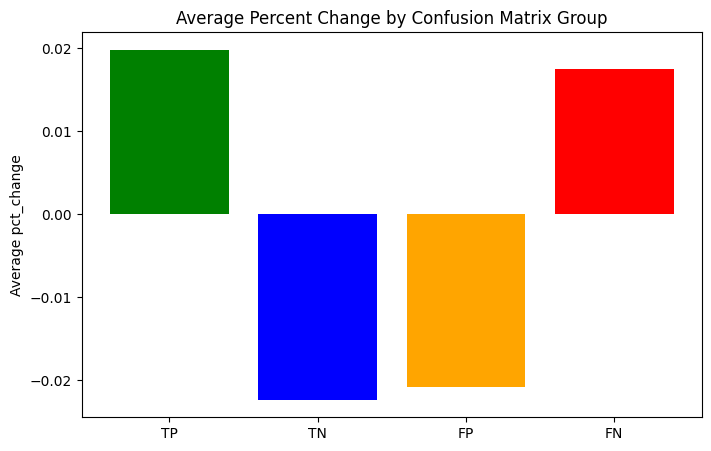

In [40]:
import matplotlib.pyplot as plt

# Compute averages from the actual groups
avg_changes = {
    "TP": df_tp['pct_change'].mean(),
    "TN": df_tn['pct_change'].mean(),
    "FP": df_fp['pct_change'].mean(),
    "FN": df_fn['pct_change'].mean()
}

# Plot
plt.figure(figsize=(8,5))
plt.bar(avg_changes.keys(), avg_changes.values(), color=["green","blue","orange","red"])
plt.ylabel("Average pct_change")
plt.title("Average Percent Change by Confusion Matrix Group")
plt.show()



It seems like the falsly identified ones are a lot closer to 0 compared to the correctly identified ones. This does show that our model is able to pick up on more extreme changes compared to less extreme ones.

In [41]:
# Compute descriptive statistics for each confusion matrix group
groups = {"TP": df_tp, "TN": df_tn, "FP": df_fp, "FN": df_fn}

for name, df_group in groups.items():
    if len(df_group) > 0:
        min_val = df_group['pct_change'].min()
        max_val = df_group['pct_change'].max()
        median_val = df_group['pct_change'].median()
        q1 = df_group['pct_change'].quantile(0.25)
        q3 = df_group['pct_change'].quantile(0.75)
        print(f"{name}:")
        print(f"  Count: {len(df_group)}")
        print(f"  Min: {min_val:.6f}, Q1: {q1:.6f}, Median: {median_val:.6f}, Q3: {q3:.6f}, Max: {max_val:.6f}\n")
    else:
        print(f"{name}: No data\n")


TP:
  Count: 107
  Min: 0.000441, Q1: 0.005514, Median: 0.017479, Q3: 0.027060, Max: 0.143616

TN:
  Count: 16
  Min: -0.174702, Q1: -0.019206, Median: -0.008454, Q3: -0.006771, Max: -0.002145

FP:
  Count: 51
  Min: -0.072335, Q1: -0.032693, Median: -0.012909, Q3: -0.005608, Max: -0.000256

FN:
  Count: 11
  Min: 0.001614, Q1: 0.007453, Median: 0.014445, Q3: 0.026265, Max: 0.037337



/tmp/ipython-input-3425640409.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, showfliers=True)


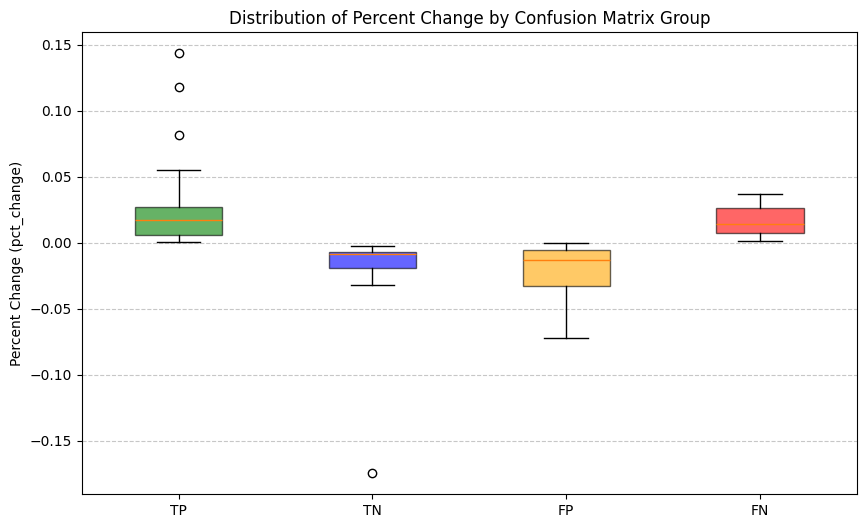

In [42]:
import matplotlib.pyplot as plt

# Prepare data for boxplot
data = [
    df_tp['pct_change'],
    df_tn['pct_change'],
    df_fp['pct_change'],
    df_fn['pct_change']
]

labels = ['TP', 'TN', 'FP', 'FN']
colors = ['green', 'blue', 'orange', 'red']

plt.figure(figsize=(10,6))
box = plt.boxplot(data, labels=labels, patch_artist=True, showfliers=True)

# Set colors for each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.ylabel('Percent Change (pct_change)')
plt.title('Distribution of Percent Change by Confusion Matrix Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
